### This is a shitty pipeline for shitty RBT SNe data reduction and retrieving the fancy lightcurve 

#### 1. Importing packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from __reader__ import *

#### 2. Reading the V- and R- data. Transforming the data to fancy and convenient catalogue

In [2]:
path_to_V = r'E:\progs\fuzzy-chainsaw\2024_2025\Photom\V'
path_to_R = r'E:\progs\fuzzy-chainsaw\2024_2025\Photom\dat\dat'

read_data(path_to_V, 'V_RBT')
read_data(path_to_R, 'R_RBT')

data_V = pd.read_csv('V_RBT.csv')
data_R = pd.read_csv('R_RBT.csv')

data_whole = pd.merge(data_V, data_R, on='id', how='inner')

id_col = data_whole.pop('id')
data_whole.insert(0, 'id', id_col)

data_whole.pop('data_y')
data_whole.pop('num_y')

data_whole['date'] = data_whole['data_x']

data_whole.pop('data_x')

date_col = data_whole.pop('date')
data_whole.insert(1, 'date', date_col)
 
data_whole.reset_index(drop=True, inplace=True)
data_whole.to_csv('RV.csv', index=False)

print(data_whole.shape)
print(data_R.shape)
print(data_V.shape)

(240, 9)
(260, 6)
(288, 6)


#### 4. ugriz -> VR_JC transformations for reference stars

In [3]:
# Lupton et al. 2005 (https://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php) 

df_rs = pd.read_csv('RS.csv')

df_rs['V_JC_PS'] = df_rs['gMeanApMag'] - 0.5784*(df_rs['gMeanApMag'] - df_rs['rMeanApMag']) - 0.0038
df_rs['R_JC_PS'] = df_rs['rMeanApMag'] - 0.2936*(df_rs['rMeanApMag'] - df_rs['iMeanApMag']) - 0.1439

df_rs['V_JC_PS_err'] = np.sqrt(0.0054**2 + df_rs['gMeanApMagErr']**2 + 0.5784**2*(df_rs['gMeanApMagErr']**2 + df_rs['rMeanApMagErr']**2))
df_rs['R_JC_PS_err'] = np.sqrt(0.0072**2 + df_rs['rMeanApMagErr']**2 + 0.2936**2*(df_rs['rMeanApMagErr']**2 + df_rs['iMeanApMagErr']**2))

df_rs.to_csv('RS.csv', index=False)

In [4]:
df_rs = pd.read_csv('RS.csv', usecols=['num', 'V_JC_PS', 'V_JC_PS_err', 'R_JC_PS', 'R_JC_PS_err'])

standarts_dict = {}
for i, row in df_rs.iterrows():
    standarts_dict.update({df_rs['num'][i] : [df_rs['V_JC_PS'][i], df_rs['V_JC_PS_err'][i], df_rs['R_JC_PS'][i], df_rs['R_JC_PS_err'][i]]})
    
standarts_dict.update({1 : [0, 0, 0, 0]})

print(standarts_dict)

{2: [16.93387121124268, 0.0070901628473458, 16.611486906433107, 0.0078815985501842], 3: [18.27946295928955, 0.0142660929209047, 17.846763305664062, 0.0112259503971785], 4: [18.033068951416016, 0.0113135835815499, 17.705330384826663, 0.0087273037438797], 1: [0, 0, 0, 0]}


In [5]:
df_rv = pd.read_csv('RV.csv')

for i, row in df_rv.iterrows():
    if (df_rv['num_x'][i] % 4) in standarts_dict:
        df_rv.at[i, 'V_JC_PS'] = standarts_dict[df_rv['num_x'][i] % 4][0]
        df_rv.at[i, 'V_JC_PS_err'] = standarts_dict[df_rv['num_x'][i] % 4][1]
        df_rv.at[i, 'R_JC_PS'] = standarts_dict[df_rv['num_x'][i] % 4][2]
        df_rv.at[i, 'R_JC_PS_err'] = standarts_dict[df_rv['num_x'][i] % 4][3]
        
    if df_rv['num_x'][i] % 4 == 0:
        df_rv.at[i, 'V_JC_PS'] = standarts_dict[4][0]
        df_rv.at[i, 'V_JC_PS_err'] = standarts_dict[4][1]
        df_rv.at[i, 'R_JC_PS'] = standarts_dict[4][2]
        df_rv.at[i, 'R_JC_PS_err'] = standarts_dict[4][3]
        
df_rv.to_csv('RV.csv', index=False)

#### 3. Trasforming VR_RBT to VR_JC (???) [3 versions, because someone is a dumbass and cannot normally explain all the algo]

In [6]:
a = -23.698
b = -0.102
c = -0.158

d = -23.578
e = -0.144
f = -0.195

X = 1.2

##### 3.1 My Version: (V_l - R_l) is color of star, which originates from catalogue

In [7]:
df_rv = pd.read_csv('RV.csv')

df_rv['R_JC_RBT_1'] = a + b*(df_rv['V_JC_PS'] - df_rv['R_JC_PS']) + c*X + df_rv['R_RBT']
df_rv['V_JC_RBT_1'] = d + e*(df_rv['V_JC_PS'] - df_rv['R_JC_PS']) + f*X + df_rv['V_RBT']

##### 3.2 General Version: solve first equation, assuming Vl, as given, and then get the Vl* (?). Doesn't make sense at all, but ok

In [8]:
df_rv['R_JC_RBT_2'] = a + b*(df_rv['V_JC_PS']) + c*X + df_rv['R_RBT']/(1+b)
df_rv['V_JC_RBT_2'] = d + e*(df_rv['V_JC_PS'] - df_rv['R_JC_RBT_2']) + f*X + df_rv['V_RBT']

##### 3.3 My version 2.0. Let's solve system of equations, Rl - Ri and Vl - Vi, taking both Rl and Vl, as unknown

In [9]:
df_rv['R_JC_RBT_3'] = df_rv['V_RBT'] + a + b*(((df_rv['V_RBT'] - df_rv['R_RBT']) - (a - d) - (c - f)*X)/(b - e)) + f*X
df_rv['V_JC_RBT_3'] = (((df_rv['V_RBT'] - df_rv['R_RBT']) - (a - d) - (c - f)*X)/(b - e)) + df_rv['R_JC_RBT_3']

In [10]:
for i, row in df_rv.iterrows():
    if df_rv['V_JC_PS'][i] == 0:
        df_rv['R_JC_RBT_1'][i] = 0
        df_rv['V_JC_RBT_1'][i] = 0
        df_rv['R_JC_RBT_2'][i] = 0
        df_rv['V_JC_RBT_2'][i] = 0
        df_rv['R_JC_RBT_3'][i] = 0
        df_rv['V_JC_RBT_3'][i] = 0

C:\Users\ALEZHA_ACTIVE\AppData\Local\Temp\ipykernel_5564\1815989419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rv['R_JC_RBT_1'][i] = 0
C:\Users\ALEZHA_ACTIVE\AppData\Local\Temp\ipykernel_5564\1815989419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rv['V_JC_RBT_1'][i] = 0
C:\Users\ALEZHA_ACTIVE\AppData\Local\Temp\ipykernel_5564\1815989419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rv['R_JC_RBT_2'][i] = 

In [11]:
df_rv.to_csv('RV.csv', index=False)

#### 6. Correct the SNe flux

In [21]:
df_rv = pd.read_csv('RV.csv')

block_size = 4

data_dict = {
    'id' : [],
    'date' : [],
    'V_JC_SNe_1' : [],
    'V_JC_SNe_2' : [],
    'V_JC_SNe_3' : [],
    'R_JC_SNe_1' : [],
    'R_JC_SNe_2' : [],
    'R_JC_SNe_3' : [],
}

# Iterate over the DataFrame in blocks
for start in range(0, len(df_rv), block_size):
    # Get the current block of rows
    block = df_rv.iloc[start:start + block_size]
    
    # Extract values from the first row of the block
    first_row = block.iloc[0]
    second_row = block.iloc[1]
    third_row = block.iloc[2]
    fourth_row = block.iloc[3]
    
    # Perform operations with the remaining rows in the block

    data_dict['V_JC_SNe_1'].append(first_row['V_RBT'] - second_row['V_RBT'] + second_row['V_JC_RBT_1'])
    data_dict['R_JC_SNe_1'].append(first_row['R_RBT'] - second_row['R_RBT'] + second_row['R_JC_RBT_1'])
    data_dict['V_JC_SNe_2'].append(first_row['V_RBT'] - third_row['V_RBT'] + third_row['V_JC_RBT_1'])
    data_dict['R_JC_SNe_2'].append(first_row['R_RBT'] - third_row['R_RBT'] + third_row['R_JC_RBT_1'])
    data_dict['V_JC_SNe_3'].append(first_row['V_RBT'] - fourth_row['V_RBT'] + fourth_row['V_JC_RBT_1'])
    data_dict['R_JC_SNe_3'].append(first_row['R_RBT'] - fourth_row['R_RBT'] + fourth_row['R_JC_RBT_1'])
    data_dict['id'].append(first_row['id'])
    data_dict['date'].append(first_row['date'])

# Create a new DataFrame from the dictionary
data_SNe = pd.DataFrame(data_dict)

data_SNe.to_csv('SNe.csv', index=False)    

In [27]:
data_SNe = pd.read_csv('SNe.csv')

V = []
R = []
V_err = []
R_err = []

for i, row in data_SNe.iterrows():
    V.append(np.median(np.array([row['V_JC_SNe_1'], row['V_JC_SNe_2'], row['V_JC_SNe_3']])))
    R.append(np.median(np.array([row['R_JC_SNe_1'], row['R_JC_SNe_2'], row['R_JC_SNe_3']])))
    V_err.append(np.std(np.array([row['V_JC_SNe_1'], row['V_JC_SNe_2'], row['V_JC_SNe_3']])))
    R_err.append(np.std(np.array([row['R_JC_SNe_1'], row['R_JC_SNe_2'], row['R_JC_SNe_3']])))

data_SNe['V'] = V
data_SNe['R'] = R
data_SNe['V_err'] = V_err   
data_SNe['R_err'] = R_err

data_SNe.to_csv('SNe.csv', index=False)

#### 6.1 Absolute magnitude of SNe

#### 7. Plot the lightcurve 

In [41]:
data_SNe = pd.read_csv('SNe.csv')

dates = list(set(data_SNe['date']))

dates = sorted(dates, key=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

V_dates = []
V_dates_err = []
R_dates = []
R_dates_err = []

for date in dates:
    V_dates.append(np.median(data_SNe[data_SNe['date'] == date]['V']))
    V_dates_err.append(np.std(data_SNe[data_SNe['date'] == date]['V']))
    R_dates.append(np.median(data_SNe[data_SNe['date'] == date]['R']))
    R_dates_err.append(np.std(data_SNe[data_SNe['date'] == date]['R']))

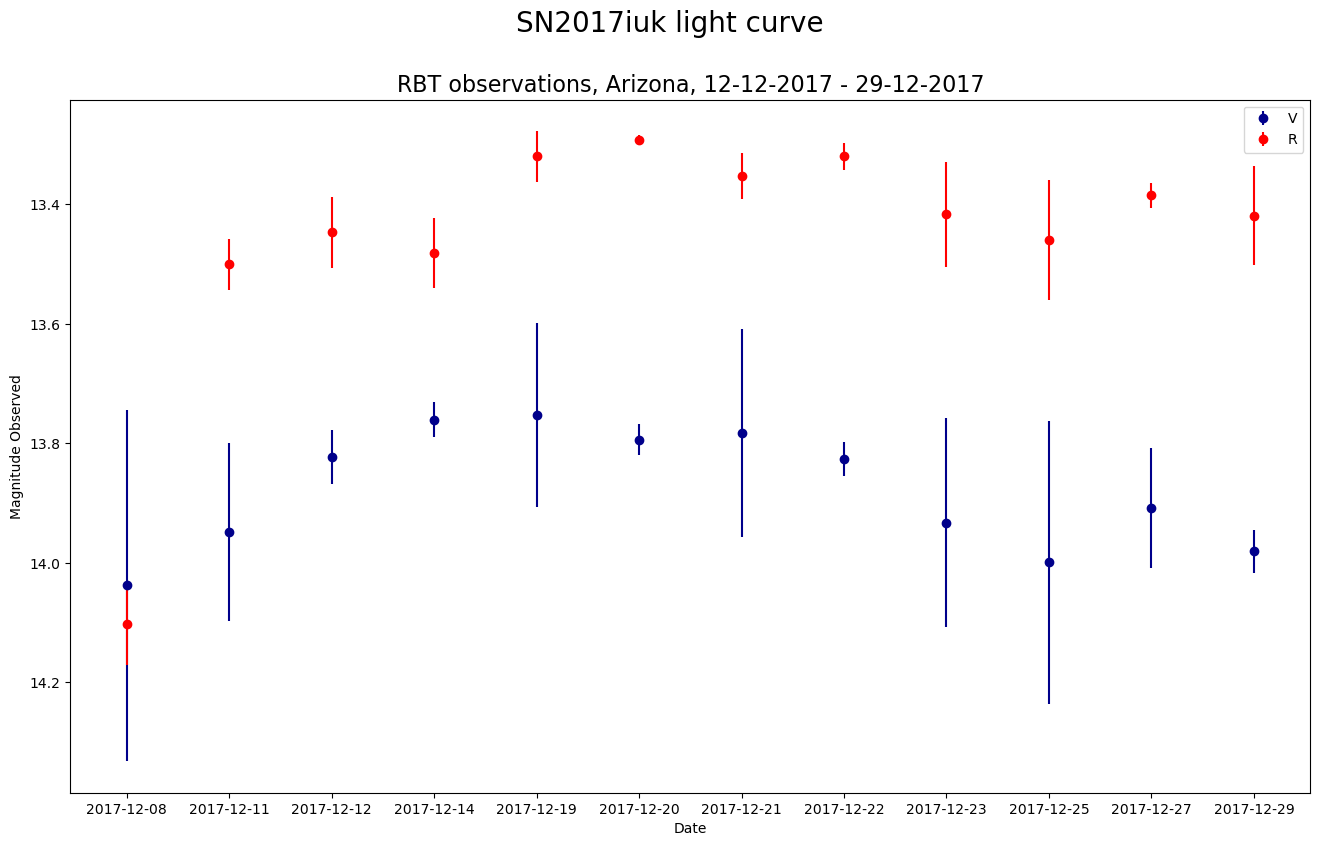

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

ax.errorbar(dates, V_dates, yerr=V_dates_err, fmt='o', color='darkblue', label='V')
ax.errorbar(dates, R_dates, yerr=R_dates_err, fmt='o', color='red', label='R')

ax.set_xlabel('Date')
ax.set_ylabel('Magnitude Observed')
ax.set_title('RBT observations, Arizona, 12-12-2017 - 29-12-2017', fontsize=16)
ax.invert_yaxis()

fig.suptitle('SN2017iuk light curve', fontsize=20)
ax.legend()

fig.savefig('SN2017iuk_light_curve.pdf', bbox_inches='tight', dpi=300)